In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import butter, filtfilt, medfilt, find_peaks, welch
import time


def load_custom_data(session_folder_path):
    """
    Loads the combined data and metadata from a custom recording session.

    Args:
        session_folder_path (str): Path to the session folder.

    Returns:
        tuple: (data_array, metadata_dict)
               - data_array (np.ndarray): The loaded data. Timestamps and TargetEvent columns might be prepended.
               - metadata_dict (dict): The loaded metadata, including session_info and potentially processed_column_names.
               Returns (None, None) if loading fails at an early stage.
    """
    data_filename = "custom_combined_data.dat"
    metadata_filename = "custom_metadata.npz"

    data_filepath = os.path.join(session_folder_path, data_filename)
    metadata_filepath = os.path.join(session_folder_path, metadata_filename)

    if not os.path.exists(metadata_filepath):
        print(f"Error: Metadata file not found: {metadata_filepath}")
        return None, None
    
    session_info_loaded = None
    metadata_loaded = None
    try:
        metadata_loaded = np.load(metadata_filepath, allow_pickle=True)
        session_info_loaded = metadata_loaded['session_info'].item()
    except Exception as e_meta:
        print(f"Error loading metadata from {metadata_filepath}: {e_meta}")
        return None, None # Cannot proceed without metadata

    if not os.path.exists(data_filepath):
        print(f"Error: Data file not found: {data_filepath}")
        return None, session_info_loaded 

    try:
        num_channels = session_info_loaded['expected_columns'] 
        data_type = np.dtype(session_info_loaded['custom_data_type'])
        data_shape_on_save = session_info_loaded.get('data_shape_on_save', 'samples_first') 
        original_column_names = list(session_info_loaded.get('column_names', [f'Ch{j+1}' for j in range(num_channels)]))

        loaded_flat_data = np.fromfile(data_filepath, dtype=data_type)

        if loaded_flat_data.size == 0:
            print("Warning: Data file is empty.")
            # Return empty array matching expected original channels, plus session_info
            empty_data = np.array([]).reshape(0, num_channels) 
            session_info_loaded['processed_column_names'] = original_column_names
            return empty_data, session_info_loaded

        processed_data = None
        final_column_names = []

        if data_shape_on_save == 'channels_first':
            if loaded_flat_data.size % num_channels == 0:
                num_samples_loaded_total = loaded_flat_data.size // num_channels
                reshaped_data_channels_first = loaded_flat_data.reshape(num_channels, num_samples_loaded_total)
                current_data_array = reshaped_data_channels_first.T  
                final_column_names = list(original_column_names) # Start with original channel names

                # Attempt to prepend timestamps and event data
                block_ts = metadata_loaded.get('data_block_timestamps', None)
                block_counts = metadata_loaded.get('data_block_sample_counts', None)
                target_event_transitions = metadata_loaded.get('target_event_transitions', None)

                if block_ts is not None and block_counts is not None and len(block_ts) > 0:
                    if sum(block_counts) == current_data_array.shape[0]: # Validate counts match data length
                        sample_timestamps = np.concatenate([np.full(int(cnt), float(ts)) for ts, cnt in zip(block_ts, block_counts)])
                        current_data_array = np.column_stack((sample_timestamps, current_data_array))
                        final_column_names.insert(0, "Timestamp")

                        # If timestamps were added, try to add event data
                        if target_event_transitions is not None and len(target_event_transitions) > 0:
                            target_event_values = np.full(len(sample_timestamps), False, dtype=bool)
                            current_event_state = False 
                            transition_idx = 0
                            for i in range(len(sample_timestamps)):
                                sample_ts_val = sample_timestamps[i]
                                while transition_idx < len(target_event_transitions) and \
                                      target_event_transitions[transition_idx][0] <= sample_ts_val:
                                    current_event_state = target_event_transitions[transition_idx][1]
                                    transition_idx += 1
                                target_event_values[i] = current_event_state
                            
                            # Insert event data after timestamp column
                            current_data_array = np.column_stack((current_data_array[:,0], target_event_values, current_data_array[:,1:]))
                            final_column_names.insert(1, "TargetEvent")
                        else:
                            print("Note: No target event transitions found in metadata or transitions array is empty.")
                    else:
                        print("Warning: Sum of block_counts does not match data length. Timestamps/Events not prepended.")
                else:
                    print("Note: data_block_timestamps or data_block_sample_counts not found or empty in metadata. Timestamps/Events not prepended.")
                
                processed_data = current_data_array
            else:
                print(f"Error: Cannot reshape data saved as 'channels_first'. Total elements ({loaded_flat_data.size}) not divisible by num_channels ({num_channels}).")
                return None, session_info_loaded
        
        else: # Assuming 'samples_first' or old format
            if loaded_flat_data.size % num_channels == 0: 
                num_samples_loaded = loaded_flat_data.size // num_channels
                processed_data = loaded_flat_data.reshape(num_samples_loaded, num_channels)
                final_column_names = list(original_column_names)
            else:
                print(f"Error: Cannot reshape data saved as 'samples_first'. Total elements ({loaded_flat_data.size}) not divisible by num_columns ({num_channels}).")
                return None, session_info_loaded

        session_info_loaded['processed_column_names'] = final_column_names
        return processed_data, session_info_loaded

    except Exception as e:
        print(f"Error processing data from {data_filepath} or applying metadata: {e}")
        import traceback
        traceback.print_exc()
        return None, session_info_loaded

# --- Configuration for loading ---
# !!! IMPORTANT !!!
# Replace 'YOUR_SESSION_FOLDER_HERE' with the actual name of the 
# subfolder in 'recorded_data/' that was created by the modified 'test_custom_save.py'.
# For example: SESSION_FOLDER_PATH = "recorded_data/20250507_103045_123456"


# <<< PLEASE UPDATE THIS PATH >>>
SESSION_FOLDER_PATH = "recorded_data/v2_LRLR_once_8_closed"

print(f"Attempting to load data from: {SESSION_FOLDER_PATH}")
loaded_data, session_metadata = load_custom_data(SESSION_FOLDER_PATH)

if session_metadata is not None: 
    print("\nSession Information (from metadata):")
    for key, value in session_metadata.items():
        if key != 'processed_column_names': # Don't print this internal-use key here
            print(f"  {key}: {value}")

    if loaded_data is not None:
        print("\nSuccessfully loaded data.")
        # Use processed_column_names from session_metadata for the header
        display_column_names = session_metadata.get('processed_column_names', 
                                                [f'Col{i+1}' for i in range(loaded_data.shape[1])])
        print(f"Data shape (samples, columns): {loaded_data.shape}")
        print(f"Columns: {display_column_names}")
        
        if loaded_data.shape[0] > 0: 
            print("\nFirst 5 rows of loaded data:")
            header = " | ".join(display_column_names)
            print(header)
            print("-" * len(header))
            for row in loaded_data[:5, :]:
                # Format each element in the row for display
                formatted_row = []
                for i, item in enumerate(row):
                    col_name = display_column_names[i] if i < len(display_column_names) else ""
                    if col_name == "Timestamp":
                        formatted_row.append(f"{item:.2f}") # Timestamp with 2 decimal places
                    elif isinstance(item, bool) or col_name == "TargetEvent":
                        formatted_row.append(str(item))    # Boolean as True/False
                    elif isinstance(item, float) or isinstance(item, np.floating):
                        formatted_row.append(f"{item:.3f}" if not np.isnan(item) else "NaN") # Floats with 3 decimal places
                    else:
                        formatted_row.append(str(item))
                print(" | ".join(formatted_row))
        else:
            print("\nData loaded, but no samples to display (data shape is 0 rows).")

        # ... (rest of the plotting code, if any, would need to be aware of new column indices)
    else: 
        print(f"\nFailed to load data array from {SESSION_FOLDER_PATH}, but metadata was available.")
        print("Please check data file integrity and error messages above.")
else: 
    print(f"\nFailed to load any data or metadata from {SESSION_FOLDER_PATH}.")
    # ... (rest of the error messages)

Attempting to load data from: recorded_data/v2_LRLR_once_8_closed

Session Information (from metadata):
  product_key: RUtYA4W3kpXi0i9C7VZCQJY5_GRhm4XL2rKp6cviwQI=
  device_id: FRENZI40
  session_start_iso: 2025-05-12T15:25:48.083168
  custom_data_type: float32
  expected_columns: 8
  data_shape_on_save: channels_first
  column_names: ['EEG_Filt_1', 'EEG_Filt_2', 'EEG_Filt_3', 'EEG_Filt_4', 'EOG_Filt_1', 'EOG_Filt_2', 'EOG_Filt_3', 'EOG_Filt_4']

Successfully loaded data.
Data shape (samples, columns): (5250, 10)
Columns: ['Timestamp', 'TargetEvent', 'EEG_Filt_1', 'EEG_Filt_2', 'EEG_Filt_3', 'EEG_Filt_4', 'EOG_Filt_1', 'EOG_Filt_2', 'EOG_Filt_3', 'EOG_Filt_4']

First 5 rows of loaded data:
Timestamp | TargetEvent | EEG_Filt_1 | EEG_Filt_2 | EEG_Filt_3 | EEG_Filt_4 | EOG_Filt_1 | EOG_Filt_2 | EOG_Filt_3 | EOG_Filt_4
-------------------------------------------------------------------------------------------------------------------------------
1747077959.15 | 0.0 | 0.760 | -2.278 | 1.398 


Values in the first and second columns (if second column is non-zero):
Row 625: 1747077964.231, 1.000
Previous value: 0.000 -> Current value: 1.000
Row 1875: 1747077974.445, 1.000
Previous value: 0.000 -> Current value: 1.000
Row 2875: 1747077982.659, 1.000
Previous value: 0.000 -> Current value: 1.000
Row 4125: 1747077992.897, 1.000
Previous value: 0.000 -> Current value: 1.000


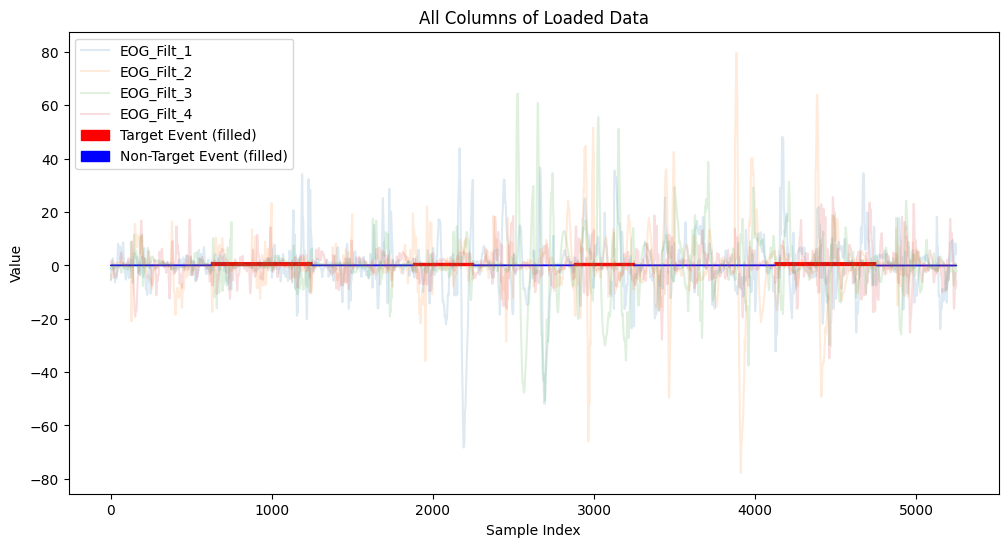

In [2]:
# metadata_loaded = np.load(
#     "recorded_data/test/custom_metadata.npz", allow_pickle=True)
# for key, value in metadata_loaded.items():
#     print(f"{key}: {value}")

# Print average of loaded_data columns

# if loaded_data is not None:
#     print("\nAverage of each column:")
#     for i in range(loaded_data.shape[1]):
#         col_name = display_column_names[i] if i < len(display_column_names) else f"Col{i+1}"
#         avg_value = np.nanmean(loaded_data[:, i])  # Use nanmean to ignore NaN values
#         print(f"{col_name}: {avg_value:.3f}")

# print values in the first and second col of loaded_data if
# there is a change between the values of the second column from the previous row
if loaded_data is not None:
    print("\nValues in the first and second columns (if second column is non-zero):")
    for i in range(loaded_data.shape[0]):
        if loaded_data[i, 1] != 0 and loaded_data[i, 1] != loaded_data[i-1, 1]:
            print(f"Row {i}: {loaded_data[i, 0]:.3f}, {loaded_data[i, 1]:.3f}")
            print(f"Previous value: {loaded_data[i-1, 1]:.3f} -> Current value: {loaded_data[i, 1]:.3f}")


# plot all columns of loaded_data
# ignore the first column
# the second column is the target event, the rest are features
# x-axis should be the time and y-axis should be the EEG/EOG signals (3rd column and onwards)
# 2nd column are 0 and 1 indicating the target event
import matplotlib.pyplot as plt

if loaded_data is not None:
    plt.figure(figsize=(12, 6))
    for i in range(6, loaded_data.shape[1]):
        col_name = display_column_names[i] if i < len(display_column_names) else f"Col{i+1}"
        plt.plot(loaded_data[:, i], label=col_name, alpha=0.15)

    # plot the target event with a different color for if the value is 0 or 1
    target_event = loaded_data[:, 1]
    # plt.plot(target_event, label="Target Event", color='red', alpha=0.5)
    plt.fill_between(range(len(target_event)), target_event, color='red', where=(target_event == 1), label="Target Event (filled)")
    plt.fill_between(range(len(target_event)), target_event, color='blue', where=(target_event == 0), label="Non-Target Event (filled)")
    # plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.title("All Columns of Loaded Data")
    plt.legend()
    plt.show()